




Teacher: Jacques Bourg    
Helper:  Gaëlle Letort

Spot detection for RNA imaging

# I- Understanding the FISH signal. 

#### Nature of the signal and orders of magnitude

<div style="text-align: center;">
  <img src="T2.png" alt="FISH imaging" width="1413" height="219">
</div>

#### What is a point spread function ? 

According to Wikipedia, the point spread function (PSF) describes the "response of a focused optical imaging system to a point source or point object".  
The image gatered though an optical imaging system results from the convolution of the real light source with the PSF. 

 
<div style="text-align: center;">
  <img src="PSF.png" alt="FISH imaging" width="298" height="272">
</div>




Wikimedia Commons contributor.  Convolution illustrated: longitudinal (XZ) central slice of a 3D image acquired by a fluorescence microscope. [9 June 2006]. Wikimedia Commons, CC BY-SA 4.0.

For more details, read the full article.
https://en.wikipedia.org/wiki/Point_spread_function


In the next section we will go in detail in what a convolution is.

##  Algorithms for spot detection

####  a) Practical introduction to the convolution operation

<p align="center">
  <img src="./2D_Convolution_Animation.gif" alt="2D Convolution Animation" title="2D Convolution Animation">
</p>

Michael Plotke. (2013). 2D Convolution Animation. Wikimedia Commons. Retrieved 02/05/2025.

In [14]:
from Conv_explorer import ConvolutionExplorer
import numpy as np
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
image = np.zeros((100, 100))
image[20:40,20:40] = 1
image[60,20] = 7
image[80,20] = 2
l = 5
image[80-l:80+l+1,80] = 1
image[80,80-l:80+l+1] = 1
image[20-l:20+l+1,80] = 3
image[20,80-l:80+l+1] = 3
image[80,50]   = 3
image[80-3,50] = 3

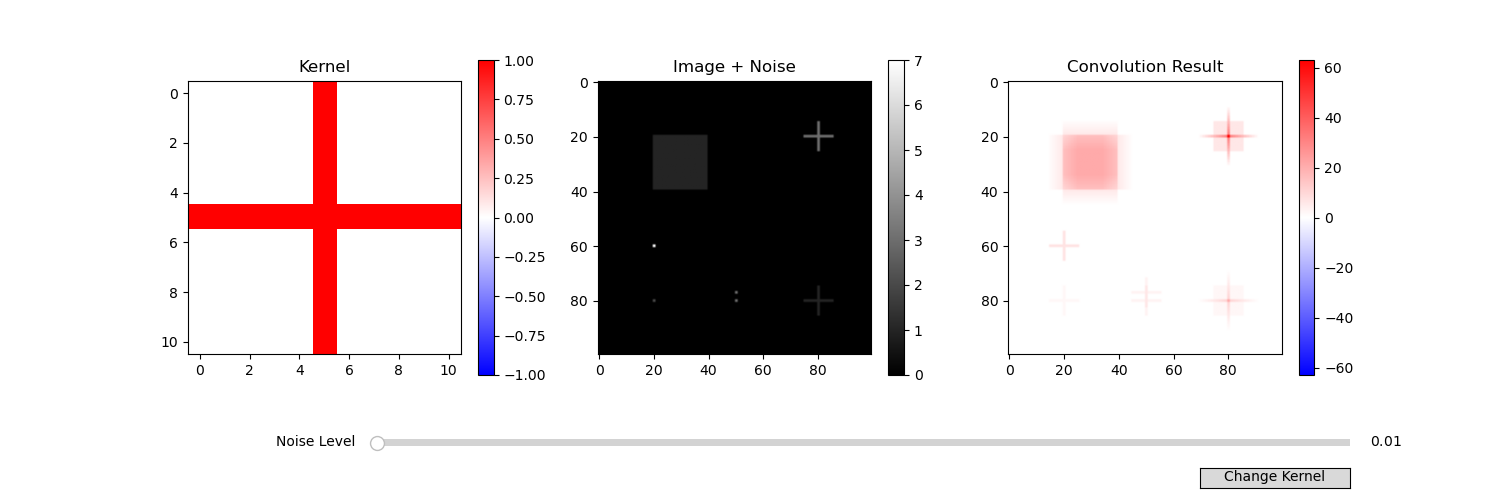

In [16]:
%matplotlib widget
explorer = ConvolutionExplorer(image)
explorer.show()

In [11]:
# markdown

# influence of the kernel size
# apparition of artifacts
# impact of the noise level on a posterior thresholding
# selectivity of kernel when the kernel has a positive and negarive part (sum = 0)
# superposition effects
# effect of the inhibition
# effect of the width of the inhibition
# noise enhancement effect
# false positive at high noise (if there was a threshold)